### Importing Libraries and Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#### Daily ridership data from 2019 to present (Q3 2024 at time of analysis).

Retrieved from https://www.wmata.com/initiatives/ridership-portal/daily-summary.cfm

In [2]:
riders_df = pd.read_csv('Daily Ridership - Data View_data.csv')
riders_df = riders_df.rename(columns={"Entries Or Boardings": "Riders"})
rail_riders_df = riders_df.query("Mode == 'Rail'").reset_index(drop=True) # filter Mode == Rail, reset indices to cardinality
bus_riders_df = riders_df.query("Mode == 'Bus'").reset_index(drop=True)
rail_riders_df.head()

,Date,Day of Week,Weekday / Saturday / Sunday,Holiday,Mode,Riders
0,7/13/2024 12:00:00 AM,Sat,Saturday,No,Rail,281859
1,7/12/2024 12:00:00 AM,Fri,Weekday,No,Rail,350029
2,7/11/2024 12:00:00 AM,Thu,Weekday,No,Rail,420907
3,7/10/2024 12:00:00 AM,Wed,Weekday,No,Rail,418040
4,7/9/2024 12:00:00 AM,Tue,Weekday,No,Rail,420731


Daily ridership is measured by proxy by boarding numbers. Note the __Day of Week__ and __Holiday__ fields - they could be useful features in a predictive ridership model.

In [3]:
# convert Dates to pandas DateTimes
rail_riders_df['Date'] = pd.to_datetime(rail_riders_df['Date'])

/tmp/ipykernel_3989/3246224945.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  rail_riders_df['Date'] = pd.to_datetime(rail_riders_df['Date'])


### Daily weather data (2019 to present)

In [4]:
weather_data = pd.read_csv('climate_data.csv')
weather_data.head()

,STATION,DATE,PRCP,SNOW,SNWD,TMAX,TMIN,TOBS,WT01,WT03,WT11
0,US1DCDC0009,2019-05-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,US1DCDC0009,2019-05-14,0.30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,US1DCDC0009,2019-05-15,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,US1DCDC0009,2019-05-16,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,US1DCDC0009,2019-05-27,0.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
weather_data.query("WT11 == 1")

,STATION,DATE,PRCP,SNOW,SNWD,TMAX,TMIN,TOBS,WT01,WT03,WT11
1288,USC00186350,2020-12-25,1.71,0.0,0.0,68.0,35.0,35.0,NaN,NaN,1.0
2185,USC00186350,2023-07-09,0.87,0.0,0.0,89.0,73.0,83.0,NaN,1.0,1.0
4590,USC00182325,2023-02-18,0.10,0.0,0.0,62.0,27.0,28.0,NaN,NaN,1.0
4607,USC00182325,2023-03-15,0.00,0.0,0.0,43.0,31.0,32.0,NaN,NaN,1.0


The WT01, WT03, and WT11 columns record fog, thunder, and damaging winds in a boolean fashion, with NaN as  false and 1.0 as true. For consistency, let's replace these NaNs with 0s.

In [6]:
weather_data['WT01'] = weather_data['WT01'].replace(np.nan, 0)
weather_data['WT03'] = weather_data['WT03'].replace(np.nan, 0)
weather_data['WT11'] = weather_data['WT11'].replace(np.nan, 0)

In [7]:
print(weather_data.query("DATE == '2019-05-15'").shape[0])
print(weather_data.query("DATE == '2021-05-23'").shape[0])

3
6


Note that there are many stations that record daily weather data, and the number of participating stations flucutates, so each date may have a different number of entries.. To get an estimate for the average weather conditions across DC for each day, we'll group by _DATE_ then take the average of the values. 

In [8]:
weather_avg_df = pd.DataFrame(data=np.sort(weather_data.DATE.unique()), columns=['DATE'])
weather_avg_df = weather_avg_df.assign(PRCP=weather_data.groupby("DATE")["PRCP"].mean().values)
weather_avg_df = weather_avg_df.assign(SNOW=weather_data.groupby("DATE")["SNOW"].mean().values)
weather_avg_df = weather_avg_df.assign(SNWD=weather_data.groupby("DATE")["SNWD"].mean().values)
weather_avg_df = weather_avg_df.assign(TMAX=weather_data.groupby("DATE")["TMAX"].mean().values)
weather_avg_df = weather_avg_df.assign(TMIN=weather_data.groupby("DATE")["TMIN"].mean().values)
weather_avg_df = weather_avg_df.assign(TOBS=weather_data.groupby("DATE")["TOBS"].mean().values)
weather_avg_df = weather_avg_df.assign(WT01=weather_data.groupby("DATE")["WT01"].mean().values)
weather_avg_df = weather_avg_df.assign(WT03=weather_data.groupby("DATE")["WT03"].mean().values)
weather_avg_df = weather_avg_df.assign(WT11=weather_data.groupby("DATE")["WT11"].mean().values)
weather_avg_df.head()

,DATE,PRCP,SNOW,SNWD,TMAX,TMIN,TOBS,WT01,WT03,WT11
0,2019-01-01,0.250,0.0,0.0,64.0,37.5,61.0,0.0,0.0,0.0
1,2019-01-02,0.000,0.0,0.0,65.0,38.0,41.0,0.0,0.0,0.0
2,2019-01-03,0.000,0.0,0.0,46.5,41.0,44.5,0.0,0.0,0.0
3,2019-01-04,0.000,0.0,0.0,49.0,31.5,33.0,0.0,0.0,0.0
4,2019-01-05,0.095,0.0,0.0,49.0,33.0,45.5,0.5,0.0,0.0


Merge the ridership and weather data

In [9]:
weather_avg_df = weather_avg_df.iloc[::-1] # weather dataframe is in chronological order, we need it in reverse order to match ridership dataframe
weather_avg_df = weather_avg_df.reset_index()
weather_avg_df = weather_avg_df.drop('index', axis=1)

# merge_df = rail_riders_df.merge(weather_avg_df, left_on='Date', right_on='DATE')
weather_avg_df.head()

,DATE,PRCP,SNOW,SNWD,TMAX,TMIN,TOBS,WT01,WT03,WT11
0,2024-07-13,0.256667,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
1,2024-07-12,0.006000,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2,2024-07-11,0.064000,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
3,2024-07-10,0.000000,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
4,2024-07-09,0.000000,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0


In [10]:
merge_df = pd.concat([rail_riders_df, weather_avg_df], axis=1)
merge_df = merge_df.drop(['DATE', 'Mode'], axis=1)

## Exploration

### Plot Rail and Bus Ridership

In [11]:
months = pd.date_range(start='2019-01-01', end='2024-07-13', freq='MS')
quarters = pd.date_range(start='2019-01-01', end='2024-07-13', freq='QS')
quarter_labels = []
for q in quarters:
    if q.month == 1:
        quarter_labels.append("Q1" + " '" + str(q.year)[2:])
    elif q.month == 4:
        quarter_labels.append("Q2" + " '" + str(q.year)[2:])
    elif q.month == 7:
        quarter_labels.append("Q3" + " '" + str(q.year)[2:])
    elif q.month == 10:
        quarter_labels.append("Q4" + " '" + str(q.year)[2:])

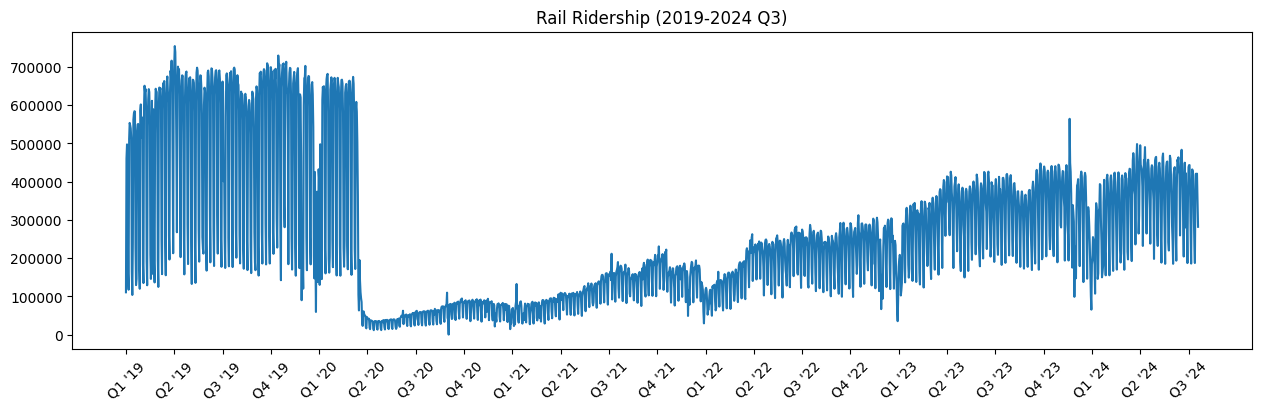

In [12]:
fig, ax = plt.subplots(layout="constrained")
fig.set_size_inches(12.5, 4)

x = merge_df.index
y = merge_df['Riders'].sort_index(ascending=False)

ax.plot(x, y, color="tab:blue")
ax.set_title("Rail Ridership (2019-2024 Q3)")
ax.tick_params(axis='x', labelrotation=45)
ax.set_xticks(np.arange(0, len(merge_df), 91), quarter_labels)

fig.show()

The elephant in the room is the pandemic, which significantly throws off the magnitude of the data around Q2 2020. This makes forecasting harder, but presents the opportunity to analyze the recovery in the years following the lockdowns. We can already observe some intriguing seasonality in the data. Note the seasonal dip around the start of each year.

### Forecast Rail Ridership Based On Day of the Week, Holiday (Y/N), and Weather Conditions

The mid-pandemic data will make predicting ridership difficult. If our dataset reached back farther in time, maybe we could use all of it to counterbalance the lockdown ridership drop-off. But if we just include all the data from 2019-2024, the predictor won't have a chance to be accurate, as __this is a time period of marked variance from the norm__. Ridership still hasn't recovered to pre-pandemic levels in 4 years. So we'll train and test our model on the timespan before the lockdown (ending at the beginning of March, 2020).

In [13]:
merge_df = merge_df.sort_index(ascending=False)[:425] # train/test data is just on 2019 - Feb 2020
merge_df = merge_df.reset_index()
merge_df = merge_df.drop(['index'], axis=1)
merge_df = merge_df.dropna() # drop all rows with any null numerical values

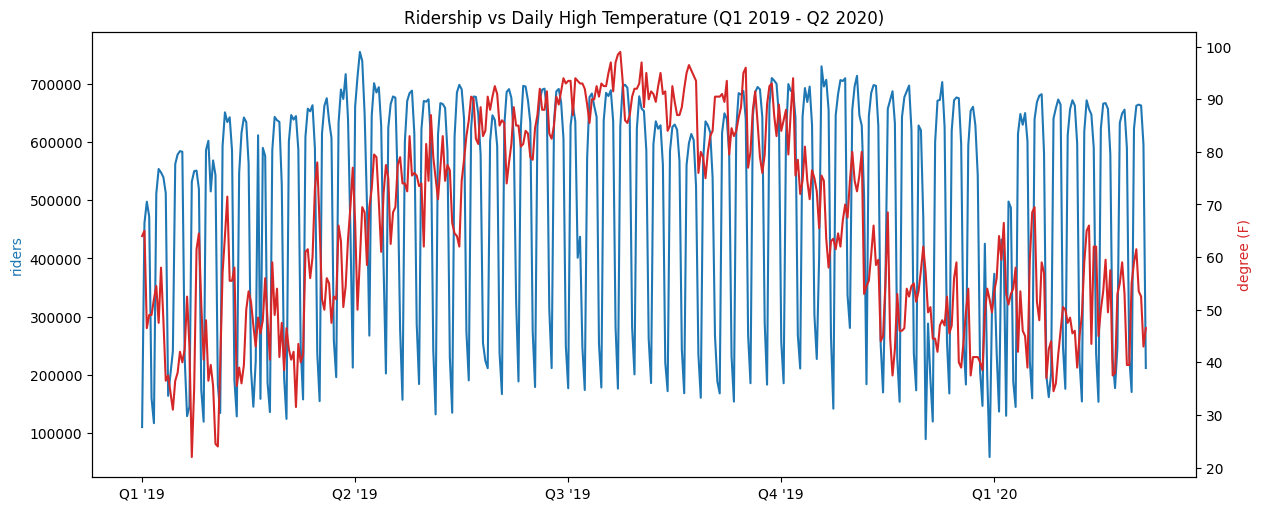

In [14]:
fig, ax = plt.subplots(layout="constrained")
fig.set_size_inches(12.5, 5)
x = merge_df.index
y = merge_df['Riders']

ax.plot(x, y, color="tab:blue")
ax.set_title("Ridership vs Daily High Temperature (Q1 2019 - Q2 2020)")
ax.set_ylabel("riders", color="tab:blue")
ax.set_xticks(np.arange(0, 425, 90), quarter_labels[:5])

y = merge_df['TMAX']
ax2 = ax.twinx()
ax2.plot(x, y, color="tab:red")
ax2.set_ylabel("degree (F)", color="tab:red")

fig.show()

In [15]:
merge_df.corr(numeric_only=True)

,Riders,PRCP,SNOW,SNWD,TMAX,TMIN,TOBS,WT01,WT03,WT11
Riders,1.000000,0.021225,-0.071725,-0.031816,0.131909,0.117658,0.087816,-0.002796,NaN,NaN
PRCP,0.021225,1.000000,0.098995,0.042939,-0.002792,0.046934,0.071509,0.063301,NaN,NaN
SNOW,-0.071725,0.098995,1.000000,0.682733,-0.169723,-0.144338,-0.149924,-0.014763,NaN,NaN
SNWD,-0.031816,0.042939,0.682733,1.000000,-0.177864,-0.159684,-0.167277,-0.014264,NaN,NaN
TMAX,0.131909,-0.002792,-0.169723,-0.177864,1.000000,0.940944,0.930102,-0.057453,NaN,NaN
TMIN,0.117658,0.046934,-0.144338,-0.159684,0.940944,1.000000,0.968014,-0.026470,NaN,NaN
TOBS,0.087816,0.071509,-0.149924,-0.167277,0.930102,0.968014,1.000000,-0.030479,NaN,NaN
WT01,-0.002796,0.063301,-0.014763,-0.014264,-0.057453,-0.026470,-0.030479,1.000000,NaN,NaN
WT03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
WT11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In the __Riders__ column, we can identify a few fields that will actually help predict ridership, specifically __SNOW__, __TMAX__, __TMIN__, and __TOBS__. Let's see how a regression model does with these fields. 

In [16]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, r2_score

In [17]:
X = merge_df[['SNOW','TMAX','TMIN','TOBS']]
y = merge_df['Riders']
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, train_size=0.3)

model = LinearRegression()
model.fit(X_train, y_train)

predictions = model.predict(X_test)
r2 = r2_score(y_test, predictions)
rmse = root_mean_squared_error(y_test, predictions)

print('The r2 is: ', r2)
print('The rmse is: ', rmse)

The r2 is:  -0.08098426773339629
The rmse is:  209569.4571368958


In [18]:
predict_df = pd.DataFrame(y_test)
predict_df.columns = ['ActualValue']

predict_df['PredValue'] = predictions
predict_df['Difference'] = predictions - y_test
predict_df['% Error'] = round(100*(predict_df['Difference']/predict_df['ActualValue']), 2)

print('Mean Difference:')
print(round(predict_df['Difference'].sum()/85, 1))
print('\n')
print('Mean Squared Difference')
print(round(predict_df['Difference'].apply(lambda value:value**2).sum()/85, 1))

Mean Difference:
-54718.4


Mean Squared Difference
153459401615.3


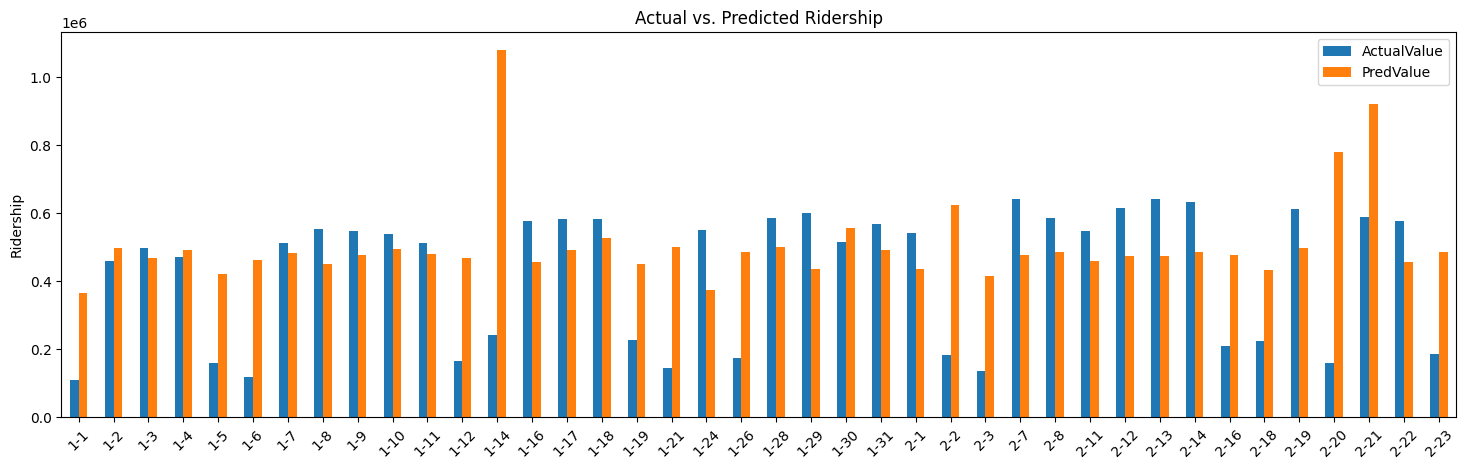

In [19]:
merge_test_df = predict_df.merge(merge_df,
                  left_on='ActualValue', right_on='Riders', how='left')
merge_test_df.sort_values(by=['Date'], inplace=True)
merge_test_df = merge_test_df.reset_index(drop=True)

merge_test_df[:40].plot(x='Date', y=['ActualValue', 'PredValue'], xlabel='', ylabel='Ridership', kind="bar", rot=45)
plt.gca().set_title('Actual vs. Predicted Ridership')
plt.gca().set_xticklabels([f"{t.month}-{t.day}" for t in merge_test_df[:40]['Date']])
plt.gca().tick_params(axis='x', labelrotation=45)
plt.gcf().set_size_inches(18, 5)

It does poorly, but these fields are not entirely useless. The categorical data from the ridership dataset (especially _Day of Week_ and _Holiday_) should be more strongly correlated to ridership. To use these fields, we'll have to encode the categories to a numerical form.

In [20]:
from sklearn.preprocessing import OneHotEncoder

# one-hot encoding for Day of Week, Weekday / Saturday / Sunday, and Holiday
categorical_columns = merge_df.select_dtypes(include=['object']).columns.tolist()
encoder = OneHotEncoder(sparse_output=False)
one_hot_encoded = encoder.fit_transform(merge_df[categorical_columns])
one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(categorical_columns))
merge_df_encoded = pd.concat([merge_df, one_hot_df], axis=1)
merge_df_encoded = merge_df_encoded.drop(categorical_columns, axis=1)
merge_df_encoded = merge_df_encoded.dropna()

In [21]:
merge_df_encoded.corr(numeric_only=True)

,Riders,PRCP,SNOW,SNWD,TMAX,TMIN,TOBS,WT01,WT03,WT11,...,Day of Week_Sat,Day of Week_Sun,Day of Week_Thu,Day of Week_Tue,Day of Week_Wed,Weekday / Saturday / Sunday_Saturday,Weekday / Saturday / Sunday_Sunday,Weekday / Saturday / Sunday_Weekday,Holiday_No,Holiday_Yes
Riders,1.000000,0.019867,-0.072274,-0.032261,0.128927,0.114736,0.084256,-0.003214,NaN,NaN,...,0.154665,-0.469802,0.263006,0.098620,0.291808,0.154665,-0.469802,0.240529,0.214592,-0.214592
PRCP,0.019867,1.000000,0.098899,0.042833,-0.003868,0.045968,0.070433,0.063188,NaN,NaN,...,0.028977,-0.019605,-0.028485,0.033701,0.026865,0.028977,-0.019605,-0.007515,-0.047080,0.047080
SNOW,-0.072274,0.098899,1.000000,0.682723,-0.170241,-0.144799,-0.150508,-0.014798,NaN,NaN,...,-0.016052,-0.001896,0.031547,0.053946,-0.048251,-0.016052,-0.001896,0.013966,0.020930,-0.020930
SNWD,-0.032261,0.042833,0.682723,1.000000,-0.178383,-0.160154,-0.167880,-0.014298,NaN,NaN,...,-0.009318,-0.039419,0.046635,0.052852,0.015550,-0.009318,-0.039419,0.037557,0.020223,-0.020223
TMAX,0.128927,-0.003868,-0.170241,-0.178383,1.000000,0.940796,0.929915,-0.057843,NaN,NaN,...,-0.000548,-0.012147,0.010843,0.016361,0.005326,-0.000548,-0.012147,0.009762,0.037142,-0.037142
TMIN,0.114736,0.045968,-0.144799,-0.160154,0.940796,1.000000,0.967957,-0.026805,NaN,NaN,...,-0.003127,-0.006027,-0.005485,0.008078,0.009454,-0.003127,-0.006027,0.007068,0.055154,-0.055154
TOBS,0.084256,0.070433,-0.150508,-0.167880,0.929915,0.967957,1.000000,-0.030885,NaN,NaN,...,0.008065,-0.008899,-0.015487,0.007481,-0.009648,0.008065,-0.008899,0.000554,0.022228,-0.022228
WT01,-0.003214,0.063188,-0.014798,-0.014298,-0.057843,-0.026805,-0.030885,1.000000,NaN,NaN,...,0.013479,-0.050686,0.132937,-0.051681,-0.051681,0.013479,-0.050686,0.028451,-0.110209,0.110209
WT03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
WT11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


With correlation coefficients > .1, the Days of the Week, Weekday, and Holiday fields are going to help us improve our predictions.

In [22]:
X = merge_df_encoded[merge_df_encoded.drop(['Date'], axis=1).columns]
y = merge_df_encoded['Riders']
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, train_size=0.8)

multi_model = LinearRegression()
multi_model.fit(X_train, y_train)

predictions = multi_model.predict(X_test)
r2 = r2_score(y_test, predictions)
rmse = root_mean_squared_error(y_test, predictions)

print('The r2 is: ', r2)
print('The rmse is: ', rmse)

The r2 is:  1.0
The rmse is:  1.9756839632941698e-10


Using all of the fields, we have $r^{2} = 1$. We've overfitted the model. 

In [23]:
features = ['SNOW', 'TMAX', 'TMIN', 'Weekday / Saturday / Sunday_Weekday', 'Holiday_No', 'Holiday_Yes']
X = merge_df_encoded[features]
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, train_size=0.8)

multi_model = LinearRegression()
multi_model.fit(X_train, y_train)

predictions = multi_model.predict(X_test)
r2 = r2_score(y_test, predictions)
rmse = root_mean_squared_error(y_test, predictions)

print('The r2 is: ', r2)
print('The rmse is: ', rmse)

The r2 is:  0.1367012701279473
The rmse is:  184453.45060204138


In [24]:
predict_df = pd.DataFrame(y_test)
predict_df.columns = ['ActualValue']

predict_df['PredValue'] = predictions
predict_df['Difference'] = predictions - y_test
predict_df['% Error'] = round(100*(predict_df['Difference']/predict_df['ActualValue']), 2)

print('Mean Difference:')
print(round(predict_df['Difference'].sum()/85, 1))
print('\n')
print('Mean Squared Difference')
print(round(predict_df['Difference'].apply(lambda value:value**2).sum()/85, 1))

Mean Difference:
2562.1


Mean Squared Difference
34023075439.0


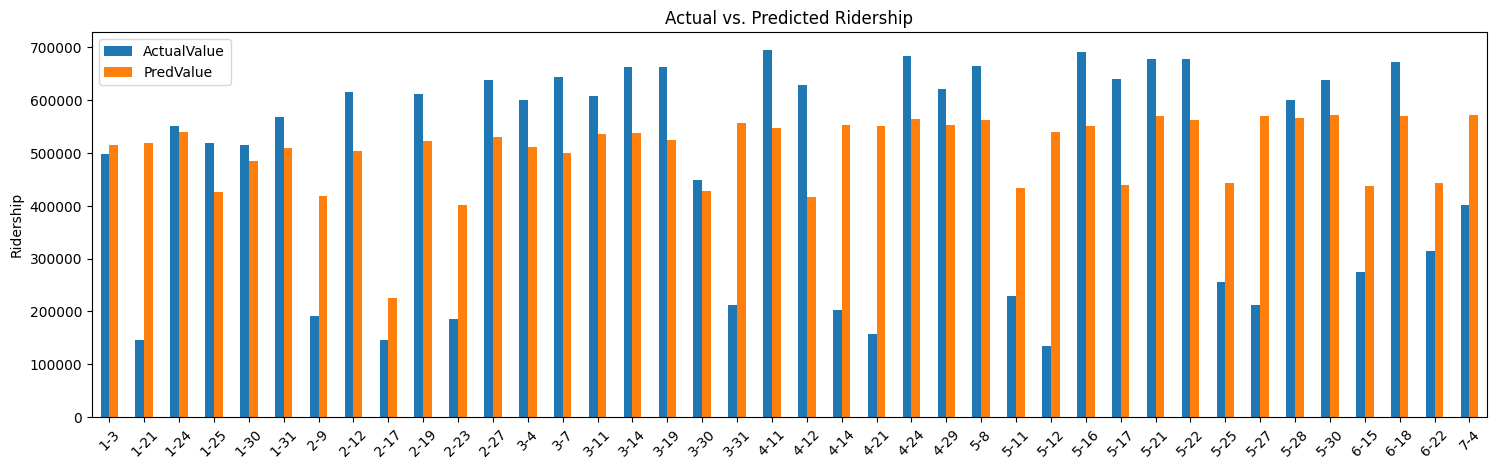

In [25]:
merge_test_df = predict_df.merge(merge_df,
                  left_on='ActualValue', right_on='Riders', how='left')
merge_test_df.sort_values(by=['Date'], inplace=True)
merge_test_df = merge_test_df.reset_index(drop=True)

merge_test_df[:40].plot(x='Date', y=['ActualValue', 'PredValue'], xlabel='', ylabel='Ridership', kind="bar", rot=45)
plt.gca().set_title('Actual vs. Predicted Ridership')
plt.gca().set_xticklabels([f"{t.month}-{t.day}" for t in merge_test_df[:40]['Date']])
plt.gca().tick_params(axis='x', labelrotation=45)
plt.gcf().set_size_inches(18, 5)

Note the visible reduction of error in the improved model. We've hit a feature sweet spot where there fewer predictions that are wildly off. The mean difference went from -54718.4 to 2562.1, a twentyfold improvement on predictive accuracy.